# Описание Задачи.
1. Необходимо провести тест между группами 0 и 3 по метрике линеаризованных лайков. Посмотреть есть ли отличие? Стало ли 𝑝−𝑣𝑎𝑙𝑢𝑒 меньше по сравнению с обычным CTR?
2. Анологичный тест необходимо провести тест между группами 1 и 2 по метрике линеаризованных лайков. 


In [17]:
import pandahouse
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import hashlib # Делать хеши
import swifter # Ускорялка метода apply
from scipy import stats # Статистика
from scipy.stats import norm, ttest_ind
%matplotlib inline

from scipy.stats import mannwhitneyu

In [18]:
# создаёт словарь с именем connection, который содержит информацию для подключения к базе данных ClickHouse.
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator'
}

# Тест между группами 0 и 3

In [19]:
# скачиваем данные из clickhouse группы 0 и 3. С '2021-11-15' по '2021-11-21'
q = """
SELECT exp_group,
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions
WHERE toDate(time) between '2021-11-15' and '2021-11-21' and exp_group in (0,3)
GROUP BY exp_group, user_id
"""
df = pandahouse.read_clickhouse(q, connection=connection)


In [20]:
df.to_excel('новый.xlsx', index=True)

Посчитаем общий CTR в контрольной группе 𝐶𝑇𝑅𝑐𝑜𝑛𝑡𝑟𝑜𝑙=𝑠𝑢𝑚(𝑙𝑖𝑘𝑒𝑠)/𝑠𝑢𝑚(𝑣𝑖𝑒𝑤𝑠) Посчитаем в обеих группах поюзерную метрику 𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘𝑒𝑠=𝑙𝑖𝑘𝑒𝑠−𝐶𝑇𝑅𝑐𝑜𝑛𝑡𝑟𝑜𝑙∗𝑣𝑖𝑒𝑤𝑠 После чего сравним t-тестом отличия в группах по метрике 𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘𝑒𝑠

In [21]:
# контрольная группа это группа 0
control_ctr = df[df.exp_group == 0].likes.sum() / df[df.exp_group == 0].views.sum()
control_ctr

0.20823612262916305

Смотрим линеаризованные лайки. Берем лайки минус CTR контроля умноженный на просмотры. Считаем и для теста и для контроля.

In [22]:
df['linearized_likes'] = df['likes'] - control_ctr * df['views']
df.head(2)

,exp_group,user_id,likes,views,ctr,linearized_likes
0,3,115383,9,30,0.300000,2.752916
1,3,123580,13,48,0.270833,3.004666


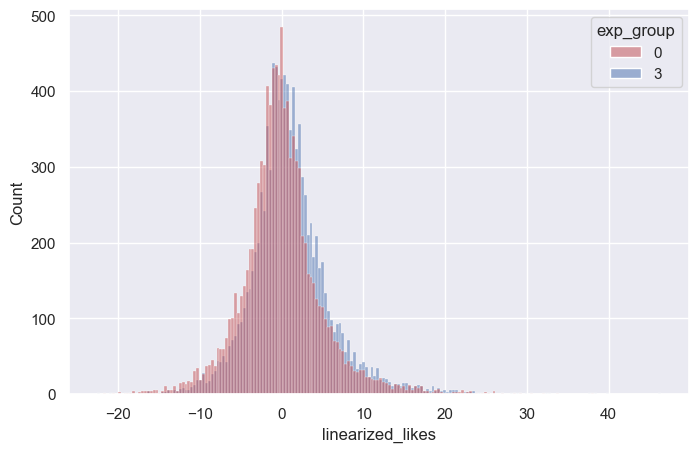

In [23]:
# смотрим распределение линеаризованной метрики
sns.set(rc={'figure.figsize':(8, 5)})
groups = sns.histplot(data=df,
                      x='linearized_likes',
                      hue='exp_group',
                      palette = ['r', 'b'],
                      alpha=0.5, 
                      kde=False)

Визуально кажеться, что одна метрика более явно сдвинута чем в другой. 

In [24]:
# сравним Т-тестом обычные CTR группы А и группы В
stats.ttest_ind(df[df.exp_group == 0].ctr,      
                df[df.exp_group == 3].ctr,
                equal_var=False)

TtestResult(statistic=-13.896870721904069, pvalue=1.055849414662529e-43, df=20032.623598070695)

Т-тестом указывает на то что есть статистически значимымые различия между контрольной и экспериментальной группой.

In [25]:
# сравним Т-тестом линеаризованные лайки группы А и группы В
stats.ttest_ind(df[df.exp_group == 0].linearized_likes,      
                df[df.exp_group == 3].linearized_likes,
                equal_var=False)

TtestResult(statistic=-15.21499546090383, pvalue=5.491424947968532e-52, df=20040.49721892551)

На линиаризованных лайках p-value совсем ничтожный. Значение нашей статистики (statistic-15) по модулю больше, а p-value сильно меньше чем показал Т-тест на обычных CTR. Это означает, что при том же различии в исходном CTR мы можем заметить меньшие изменения. То есть метрика стала более чувствительной.

# Тест между группамиы  1 и 2
Проверим тоже самое, работоспособность метода линеаризации на тесте с группами 1 и 2

In [26]:
# скачиваем данные из clickhouse группы 1 и 2. С '2021-11-15' по '2021-11-21'
q = """
SELECT exp_group,
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions
WHERE toDate(time) between '2021-11-15' and '2021-11-21' and exp_group in (1,2)
GROUP BY exp_group, user_id
"""
df = pandahouse.read_clickhouse(q, connection=connection)


In [27]:
df.to_excel('новый_2.xlsx', index=True)

In [28]:
# контрольная группа это группа 1
control_ctr = df[df.exp_group == 1].likes.sum() / df[df.exp_group == 1].views.sum()
control_ctr

0.20802680490126244

In [29]:
df['linearized_likes'] = df['likes'] - control_ctr * df['views']
df.head(2)

,exp_group,user_id,likes,views,ctr,linearized_likes
0,1,109963,3,15,0.20000,-0.120402
1,1,26117,32,141,0.22695,2.668221


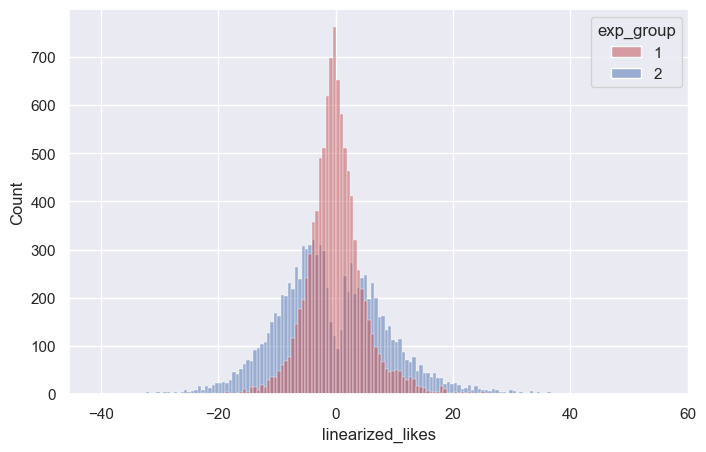

In [30]:
# смотрим распределение линеаризованной метрики
sns.set(rc={'figure.figsize':(8, 5)})
groups = sns.histplot(data=df,
                      x='linearized_likes',
                      hue='exp_group',
                      palette = ['r', 'b'],
                      alpha=0.5, 
                      kde=False)

Получили график линеаризованых лайков, в одной группе это расспределение сгрудилось около нуля (потому что мы ровно его среднее вычли). Второе распределение стало чуть более нормализованным, оно центрировалось более симетричным стало. Провал остался, но на нормальность явно больше подходит чем было раньше. 

In [31]:
# сравним Т-тестом линеаризованные лайки группы А и группы В
stats.ttest_ind(df[df.exp_group == 1].linearized_likes,      
                df[df.exp_group == 2].linearized_likes,
                equal_var=False)

TtestResult(statistic=6.122579994775972, pvalue=9.439432187037815e-10, df=14823.29033279499)

На линеаризованое метрики Т-тест очень уверено прокрасился и говорит нам что отличие в группах есть. Как мы и видели на других тестах, которые могли работать с сильно не нормальными расспределениями. 

**Вывод:**

При ненормальном распределении Т-тест нечувствителен, если же мы применим линеаризацию то тот же Т-тест станет чувствительным.